In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer

import matplotlib
import matplotlib.pyplot as plt

tf.compat.v1.enable_v2_behavior()

In [2]:
class CardGameEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._state = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state], dtype=np.int32))

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    # Make sure episodes don't go on forever.
    if action == 1:
      self._episode_ended = True
    elif action == 0:
      new_card = np.random.randint(1, 11)
      self._state += new_card
    else:
      raise ValueError('`action` should be 0 or 1.')

    if self._episode_ended or self._state >= 21:
      reward = self._state - 21 if self._state <= 21 else -21
      return ts.termination(np.array([self._state], dtype=np.int32), reward)
    else:
      return ts.transition(
          np.array([self._state], dtype=np.int32), reward=0.0, discount=1.0)

In [3]:
environment = CardGameEnv()
utils.validate_py_environment(environment, episodes=5)

In [4]:
get_new_card_action = np.array(0, dtype=np.int32)
end_round_action = np.array(1, dtype=np.int32)

environment = CardGameEnv()
time_step = environment.reset()
print(time_step)
cumulative_reward = time_step.reward

for _ in range(3):
  time_step = environment.step(get_new_card_action)
  print(time_step)
  cumulative_reward += time_step.reward

time_step = environment.step(end_round_action)
print(time_step)
cumulative_reward += time_step.reward
print('Final Reward = ', cumulative_reward)

TimeStep(step_type=array(0), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0]))
TimeStep(step_type=array(1), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([4]))
TimeStep(step_type=array(1), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([12]))
TimeStep(step_type=array(1), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([14]))
TimeStep(step_type=array(2), reward=array(-7., dtype=float32), discount=array(0., dtype=float32), observation=array([14]))
Final Reward =  -7.0


In [5]:
import sqlite3
from datetime import datetime
conn = sqlite3.connect('dblogs/20201114.db')
c = conn.cursor()

In [6]:
def get(exchange, start, end):
        sql = f'SELECT * FROM btcjpy where exchange = "{exchange}" AND unixtime >= {start} AND unixtime < {end} order by unixtime desc'

        resp = []
        for row in c.execute(sql):
            print(row)
            asks = []
            bids = []
            for i in range(1, 1):
                asks.append([row[f'ask{i}'], row[f'asksize{i}']])
                bids.append([row[f'bid{i}'], row[f'bidsize{i}']])
                resp.append({
                    'timestamp': row['unixtime'],
                    'asks': asks,
                    'bids': bids
                })
        return resp

In [7]:
from db import DB

In [8]:
mydb = DB(20201114, 4)
EXC = ['bitflyer', 'liquid', 'zaif', 'coincheck']

In [9]:
baseTime = datetime(2020, 11, 14, 0, 0, 0).timestamp()

In [10]:
amounts = {}
for ex in EXC:
    amounts[ex] = {
        'asks': [],
        'bids': []
    }
    for type in ['asks', 'bids']:
        curTime = baseTime
        while(curTime < baseTime + 60*60):
            res = mydb.get(ex, curTime, curTime + 10)
            start = 0
            min = 100000000
            maxv = 0
            for row in res:
                val = row[type][0][0]
                if start == 0:
                    start = val
                end = val
                if val < min:
                    min = val
                if val > maxv:
                    maxv = val
            curTime += 10
            amounts[ex][type].append({
                'timestamp': curTime,
                'start': start,
                'end': end,
                'min': min,
                'max': maxv
            })

In [11]:
def ml(func, array):
    return list(map(func, array))

In [12]:
import pandas as pd
head = next(iter(amounts))
prices = pd.DataFrame({
    'time': ml(lambda a:datetime.fromtimestamp(a['timestamp']), amounts[head]['asks'])
})
for ex in EXC:
    prices[ex] = ml(lambda a:a['start'], amounts[ex]['asks'])
prices.head()

,time,bitflyer,liquid,zaif,coincheck
0,2020-11-14 00:00:10,1701582.0,1700479.0,1702000.0,1701256.0
1,2020-11-14 00:00:20,1702164.0,1701093.0,1702265.0,1702099.0
2,2020-11-14 00:00:30,1702200.0,1701861.0,1702610.0,1702175.0
3,2020-11-14 00:00:40,1701871.0,1700969.0,1702360.0,1702127.0
4,2020-11-14 00:00:50,1702197.0,1701748.0,1702800.0,1702023.0


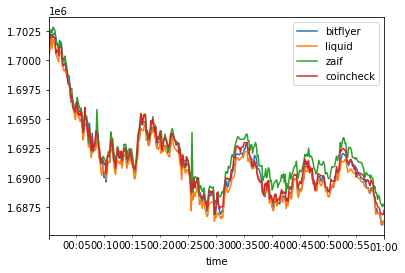

In [13]:
prices.plot(x='time',y=EXC)

In [14]:
c = 0
prices[c:c+1]

,time,bitflyer,liquid,zaif,coincheck
0,2020-11-14 00:00:10,1701582.0,1700479.0,1702000.0,1701256.0


In [15]:
for ex in EXC:
    prices = mydb.get(ex, baseTime, curTime + 10)
    res = ml(lambda p:p['asks'], prices)

In [30]:
import pandas as pd
NONE = 0
BUY = 1
SELL = 2

BUYAMOUNT = 0.01
EXLEN = len(EXC)

class BTCTradeEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=8, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1,968), dtype=np.float32, minimum=0, maximum=10000000, name='observation')
    # 残高1万円~50万円, 0.01BTC~0.5BTC
    # 過去１分間(3*20)の価格
    self._episode_ended = False
    self._asks = {}
    self._bids = {}
    self._maxCnt = 0
    for ex in EXC:
      prices = mydb.get(ex, baseTime, curTime + 60*60*24)
      # example for self._asks[ex]
      # [[[1701256.0, 0.0001], [1701501.0, 0.005], [1701505.0, 0.01015336]],
      # [[1701316.0, 0.01], [1701494.0, 0.01275137], [1701500.0, 0.02]],
      # [[1702132.0, 0.02440992], [1702180.0, 0.1], [1702290.0, 0.08]]]
      self._asks[ex] = ml(lambda p:p['asks'], prices)
      self._bids[ex] = ml(lambda p:p['bids'], prices)
      self._maxCnt = max([self._maxCnt, len(self._asks[ex])])
    self._maxCnt = len(self._asks[head]) - 1
    self._initVal()

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._episode_ended = False
    self._initVal()
    return ts.restart(np.array([self._state], dtype=np.float32))
  
  def _initVal(self):
    # ランダム時間から開始
    self._stepCnt = np.random.randint(0, self._maxCnt-129)
    self._startCnt = self._stepCnt
    # ランダムな所持金で開始
    jpy = np.random.randint(10000, 1000000, EXLEN).tolist()
    btc = (abs(np.random.randn(EXLEN))+0.01).tolist()
    self._state = jpy + btc + [0]*960
    self._step(0)
    self._initJPY = self._valuationJPY(self._state)
    self._initBTC = self._valuationBTC(self._state)
  
  # 円換算評価額
  def _valuationJPY(self, state):
    total = 0
    for i in range(EXLEN):
      jpy = self._state[i]
      btc = self._state[EXLEN + i]
      ask = self._state[int(EXLEN*2)]
      total += jpy + btc * ask
    return total

  # BTC換算評価額
  def _valuationBTC(self, state):
    total = 0
    for i in range(EXLEN):
      jpy = self._state[i]
      btc = self._state[EXLEN + i]
      ask = self._state[int(EXLEN*2)]
      total += btc
      if ask > 0:
        total += jpy / ask
    return total

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    cnt = self._stepCnt
    # stateから情報を抜出
    jpyBal = self._state[0:EXLEN]
    btcBal = self._state[EXLEN:EXLEN*2]
    board = self._state[EXLEN*2:EXLEN*2+960]

    # 1フレーム前の板情報を反映
    frameSize = int(len(board) / 20)
    board[frameSize:len(board)] = board[0:(len(board)-frameSize)]

    # 最新板情報を更新
    cur = 0
    for ex in EXC:
      for ab in [self._asks, self._bids]:
        for dep in range(3):
          # 金額
          board[cur] = ab[ex][cnt:cnt+1][0][dep][0]
          cur += 1
          # 量
          board[cur] = ab[ex][cnt:cnt+1][0][dep][1]
          cur += 1

    # Make sure episodes don't go on forever.
    if action != 0:
      # 売買 次のフレームの価格で購入できる
      exidx = (action - 1) % EXLEN
      ex = EXC[exidx]
      buy = action <= EXLEN
      if buy:
        target = self._asks[ex][cnt+1:cnt+2][0]
        # 買える分だけ買う
        remain = BUYAMOUNT
        for dep in range(3):
          price = target[dep][0]
          amount = target[dep][1]
          if remain <= amount:
            amount = remain
          jpy = price * amount
          if jpyBal[exidx] < jpy:
            break
          jpyBal[exidx] -= jpy
          btcBal[exidx] += amount
          remain -= amount
          if remain <= 0:
            break
      else:
        target = self._bids[ex][cnt+1:cnt+2][0]
        # 売れる分だけ売る
        remain = BUYAMOUNT
        for dep in range(3):
          price = target[dep][0]
          amount = target[dep][1]
          if remain <= amount:
            amount = remain
          if btcBal[exidx] < amount:
            break
          jpyBal[exidx] += price * amount
          btcBal[exidx] -= amount
          remain -= amount
          if remain <= 0:
            break

    # state更新
    self._state = jpyBal + btcBal + board

    # 3秒時間を進める
    self._stepCnt += 1
    if self._stepCnt >= self._maxCnt:
      self._episode_ended = True

    # 最大128フレームで終了
    frameCnt = self._stepCnt - self._startCnt
    if frameCnt > 128:
      self._episode_ended = True
    
    reward = 1
    if frameCnt > 1:
      jpy = self._valuationJPY(self._state)
      btc = self._valuationBTC(self._state)
      reward = jpy / self._initJPY + btc / self._initBTC - 2

    # 5%所持金が減ったら強制終了
    if reward < -0.1:
      self._episode_ended = True

    if self._episode_ended:
      # 初期所持金から何倍増えたかが報酬
      return ts.termination(np.array([self._state], dtype=np.float32), reward)
    else:
      return ts.transition(
          np.array([self._state], dtype=np.float32), reward=0.0, discount=1.0)

In [31]:
environment = BTCTradeEnv()
utils.validate_py_environment(environment, episodes=1)

AttributeError: 'BTCTradeEnv' object has no attribute '_initJPY'

In [18]:
environment._state[0:8]

[275856,
 871228,
 698017,
 170396,
 0.8614019445682229,
 0.9256111302174068,
 0.8113972030583734,
 1.0262824218292126]

In [19]:
environment._valuationJPY(environment._state)

8183208.85329535

In [20]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [21]:
train_py_env = BTCTradeEnv()
eval_py_env = BTCTradeEnv()
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [22]:
fc_layer_params = (960,480,240,480,960)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [23]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [24]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [25]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [26]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

KeyboardInterrupt: 

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [ ]:
agent.collect_data_spec

In [ ]:
agent.collect_data_spec._fields

In [ ]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)


In [ ]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2,
    single_deterministic_pass=False).prefetch(3)

In [ ]:
iterator = iter(dataset)

print(iterator)

In [ ]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
# plt.ylim(top=250)